The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

def camera_calibration(link='camera_cal/calibration*.jpg'):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(link)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    return objpoints, imgpoints

def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)
            
def advance_procces(image):
    (b, g, r) = cv2.split(image)
    c1 = (b < 120) & (r > 140) & (g > 140)
    c2 = (b > 180) & (r > 180) & (g > 180)
    binary_1 = np.zeros_like(b)
    binary_2 = np.zeros_like(b)
    binary_1[c1]=1
    binary_2[c2]=1
    bitwise_or = cv2.bitwise_or(binary_1, binary_2)
    return bitwise_or

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

def measure_curvature_pixels(ploty,left_fit, right_fit,):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    mid_imgx = img_shape[1]//2      
    car_pos = (leftx[-1] + rightx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_per_pix
    return offsetx

def annotation(img_lane, combo, leftx, rightx, ploty, left_fit, right_fit):
    left_curverad,right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
    # Display curvature_rad 
    cv2.putText(img_lane, 'curvature: {:.2f} m'.format(left_curverad), (300, 60), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    #cv2.putText(img_lane, 'Right curvature: {:.2f} m'.format(right_curverad), (300, 110), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    # Display car offset
    #offset = car_offset(leftx, rightx, img_lane.shape)
    #cv2.putText(img_lane, 'Offset w.r.t center: {:.2f} m'.format(offset), (300, 160), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    
def draw_lane(img, warp, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    reverse_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, reverse_warp, 0.3, 0)

In [2]:
def find_lane_pixels(binary_warped):
    global prev_left_fit  
    global prev_right_fit
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    delta = rightx_base - leftx_base
    
    # Set height of windows - based on nwindows above and image shape
    nonzero_left = binary_warped[:,:midpoint].nonzero()
    lefty = np.array(nonzero_left[0])
    leftx = np.array(nonzero_left[1])
    nonzero_right = binary_warped[:,midpoint:].nonzero()
    righty = np.array(nonzero_right[0])
    rightx = np.array(nonzero_right[1]) + midpoint
    
    
    if  leftx.size > 3 and rightx.size > 3:
        x = np.append(leftx, rightx-delta, axis=0)
        y = np.append(lefty, righty, axis=0)
        left_fit = np.polyfit(y, x, 2)
        right_fit = np.polyfit(y, x, 2)
        right_fit[2] = right_fit[2]+delta
        
        prev_left_fit = left_fit
        prev_right_fit = right_fit
    else: 
        left_fit = prev_left_fit
        right_fit = prev_right_fit
            # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #except TypeError:
    # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
    #    print('The function failed to fit a line!')
    #    ret = 'False' 
    #left_fitx = 1*ploty**2 + 1*ploty
    #right_fitx = 1*ploty**2 + 1*ploty
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty

In [3]:
# preparation step 1: find the objpoints, imgpoints from camera calibration
objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');
# preparation step 2: identify the Perspective Transform matrix M by the given source and destination points
src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
# build the pipeline

def pipeline(img):
    global prev_left_fit  
    global prev_rightx_fit
    t=60
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # need to commnet this one when you run images
    
    objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');
    src = np.float32(
        [[280,  700],  # Bottom left
         [595,  460],  # Top left
         [725,  460],  # Top right
         [1125, 700]]) # Bottom right
    dst = np.float32(
        [[250,  720],  # Bottom left
         [250,    0],  # Top left
         [1065,   0],  # Top right
         [1065, 720]]) # Bottom right
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
#step 1: obatin the undistort image 
    undistorted = cal_undistort(img, objpoints, imgpoints)
#step 2: apply Perspective Transform matrix M to "bird-view" 
    img_size = (undistorted.shape[1], undistorted.shape[0])
    warped = cv2.warpPerspective(undistorted, M, img_size)
#step 3: color detetion to have robust lane detetion
    if np.mean(warped) > 100:
        background = np.ones(warped.shape, dtype="uint8") * 20
    elif np.mean(warped) > 60:
        background = np.ones(warped.shape, dtype="uint8") * 0
    else: 
        background = np.ones(warped.shape, dtype="uint8") * (-20)    
    subtracted_image = cv2.subtract(warped, background)
    combo = advance_procces(subtracted_image)
#step 4: apply the polynomial fit on histogram 
    leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = find_lane_pixels(combo)
#step 5 Warp the detected lane boundaries back onto the original image
    img_lane = draw_lane(img, combo, (left_fitx, ploty), (right_fitx, ploty), Minv)
#step 6 annotate metrics onto the origianl image
    annotation(img_lane, combo, leftx, rightx, ploty, left_fit, right_fit)
    return img_lane
    #return plt.imshow(img_lane)

## Test on Image (need to be tested in BGR )

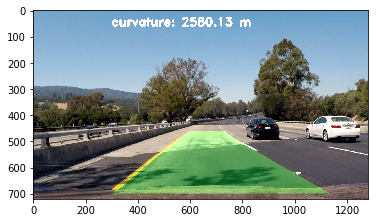

In [10]:
#need to commenct this on in pipiline
#img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # need to commnet this one when you run images

left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
test_img_list= os.listdir("test_images/")
img_name = test_img_list[2]
img = cv2.imread("test_images/" + img_name)
pipeline(img)
plt.show()

In [38]:
test_img_list= os.listdir("test_images/")
for i in range(0,len(test_img_list)):
    img_name = test_img_list[i]
    img = cv2.imread("test_images/" + img_name)
    pipeline(img)
    plt.show()

## Test on Video 

In [4]:
#need to uncommenct this on in pipiline
#img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # need to uncommnet this one when you run video

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
out_dir = 'test_videos_output'
if os.path.exists(out_dir)==0:
    os.mkdir(out_dir)

In [5]:
prev_left_fit  = np.array([ 2.21903007e-04, -2.02707371e-01,  2.72740313e+02])
prev_right_fit = np.array([ 2.21903007e-04, -2.02707371e-01,  1.09674031e+03])
white_output = './test_videos_output/project_video_annotated.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4').subclip(0,1)
white_clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./test_videos_output/project_video_annotated.mp4.
Moviepy - Writing video ./test_videos_output/project_video_annotated.mp4



OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file ./test_videos_output/project_video_annotated.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

In [9]:
prev_left_fit

array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])